In [59]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./utils')  # or use full path if needed

from trend_regime_utils import load_trend_data, process_trend_data, create_advanced_feat, mayority_vote_cluster_smooth

import pandas as pd
import numpy as np
from datetime import datetime
from zoneinfo import ZoneInfo
import joblib
from scipy.stats.mstats import winsorize

# For API Keys
import os
from dotenv import load_dotenv
# Alpaca API keys
API_KEY = None
SECRET_KEY = None

load_dotenv(override=True)

if API_KEY is None:
    API_KEY = os.environ.get('ALP_API_KEY')

if SECRET_KEY is None:
    SECRET_KEY = os.environ.get('ALP_SEC_KEY')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
EARLIEST_DATE = datetime(2016, 1, 16, tzinfo=ZoneInfo('America/New_York'))
LAST_DATE = datetime(2025, 7, 20, tzinfo=ZoneInfo('America/New_York'))

df_trend_raw = load_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE)

df_trend_processed = process_trend_data(df_trend_raw)

df_trend_feat = create_advanced_feat(df_trend_processed)

c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:94: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:94: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:94: FutureWar

In [61]:
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

## If want to predict
# Load models
scaler = joblib.load(os.path.join(MODEL_DIR, "trend_scaler.pkl"))
umap_model = joblib.load(os.path.join(MODEL_DIR, "trend_umap_model.pkl"))
gmm_model = joblib.load(os.path.join(MODEL_DIR, "trend_gmm_model.pkl"))

# scale data
trend_scaled = scaler.transform(df_trend_feat)

# Apply UMAP transformation
trend_umap = umap_model.transform(trend_scaled)

# Predict clusters
trend_gmm_labels = gmm_model.predict(trend_umap)

# from sklearn.metrics import silhouette_score
# print(silhouette_score(trend_umap, trend_gmm_labels))

df_with_clusters = pd.DataFrame(trend_gmm_labels, columns=["cluster"], index=df_trend_feat.index)

df_cluster_smooth = mayority_vote_cluster_smooth(df_with_clusters)

In [62]:
# Example list – customize based on your actual dataset
us_global_equities = ['SPY', 'QQQ', 'DIA', 'IWM', 'EFA', 'EEM', 'VEA', 'VWO']
other_tickers = ['TLT', 'GLD', 'SPHB', 'SPLV']
bull_tickers = us_global_equities+other_tickers
df_bull_raw = load_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE, all_tickers=bull_tickers)

print(df_bull_raw.pivot(columns='symbol').isna().sum())

      symbol
open  DIA       0
      EEM       0
      EFA       0
      GLD       0
      IWM       0
               ..
vwap  SPLV      0
      SPY       0
      TLT       0
      VEA       0
      VWO       0
Length: 84, dtype: int64


In [63]:
# --- Configuration ---
ROLLING_WINDOW = 20  # You can adjust this

df_eq = df_bull_raw[df_bull_raw['symbol'].isin(us_global_equities)].sort_index().copy()
df_eq_mean = df_eq.groupby(df_eq.index).mean(numeric_only=True)

# --- Feature 1: Trend Consistency Score ---
df_eq_mean['trend_consistency'] = ((df_eq_mean['close'] - df_eq_mean['low']) / 
                                (df_eq_mean['high'] - df_eq_mean['low'] + 1e-6)).rolling(ROLLING_WINDOW).mean()

# --- Feature 8: Volume Trend Divergence ---
df_eq_mean['volume_trend_divergence'] = (
    df_eq_mean['close'].pct_change().rolling(ROLLING_WINDOW)
    .corr(df_eq_mean['volume'].rolling(ROLLING_WINDOW).mean())
)


In [64]:
# --- Helper function to extract close price of a symbol ---
def get_close(symbol):
    return df_bull_raw[df_bull_raw['symbol'] == symbol].sort_index()['close']

# Get closes for external tickers
tlt = get_close('TLT')
gld = get_close('GLD')
sphb = get_close('SPHB')
splv = get_close('SPLV')

external_df = pd.DataFrame(index=df_eq_mean.index)

# --- High Beta vs. Low Volatility Spread ---
external_df['beta_vol_spread'] = sphb.pct_change().rolling(ROLLING_WINDOW).mean() - \
                                  splv.pct_change().rolling(ROLLING_WINDOW).mean()

# --- Correlations ---
external_df['glob_eq_tlt_corr'] = df_eq_mean['close'].pct_change().rolling(ROLLING_WINDOW).corr(tlt.pct_change())
external_df['glob_eq_gld_corr'] = df_eq_mean['close'].pct_change().rolling(ROLLING_WINDOW).corr(gld.pct_change())

In [65]:
# Combine SPY-only features and external features
bull_features_df = pd.concat([df_eq_mean[['trend_consistency', 'volume_trend_divergence']],
                         external_df], axis=1)

# Optional: Drop rows with missing values
print(bull_features_df.isna().sum())
bull_features_df.dropna(inplace=True)


trend_consistency          19
volume_trend_divergence    38
beta_vol_spread            20
glob_eq_tlt_corr           20
glob_eq_gld_corr           20
dtype: int64


In [66]:
# keep only bull days 
bull_days = df_cluster_smooth[df_cluster_smooth==1]

# Keep only rows in bull_features_df where the index exists in bull_days
only_bull_features_df = bull_features_df[bull_features_df.index.isin(bull_days.index)]

In [67]:
N_COMP=3
N_NEIG=40
MIN_D = 0.01
METRIC = "euclidean"

RANDOM_STATE = 4

K=2

from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap


# Store results
results = []

scaled = StandardScaler().fit_transform(only_bull_features_df.values)

# Apply UMAP
X_umap = umap.UMAP(
    n_neighbors=N_NEIG,
    min_dist=MIN_D,
    n_components=N_COMP,
    metric=METRIC,
    random_state=RANDOM_STATE
).fit_transform(scaled)

model = SpectralClustering(
    n_clusters=K,
    affinity='rbf',
    assign_labels='kmeans',
    random_state=RANDOM_STATE
)
labels = model.fit_predict(X_umap)

sil = silhouette_score(X_umap, labels)
ch = calinski_harabasz_score(X_umap, labels)
db = davies_bouldin_score(X_umap, labels)
print("silhouette_score", sil)

c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


silhouette_score 0.539320707321167


C:\Users\sergi\AppData\Local\Temp\ipykernel_1432\206538882.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('coolwarm', n_clusters)  # get n discrete colors from RdBu


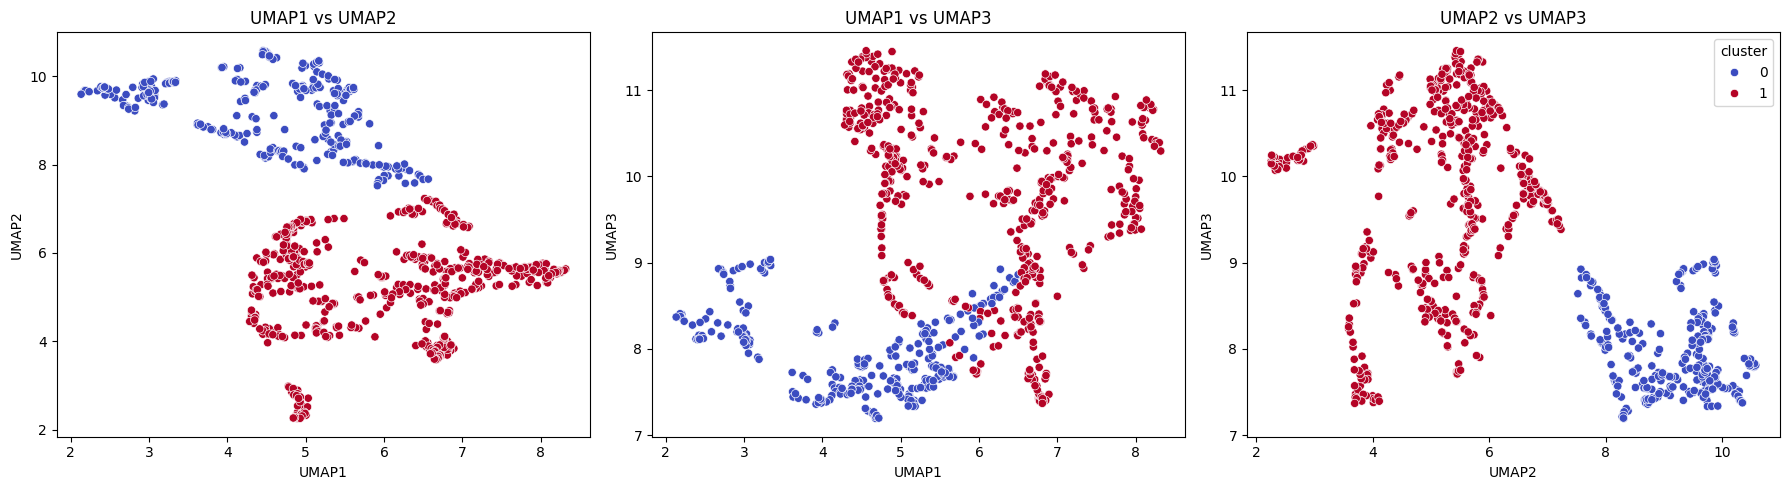

In [91]:
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex

# Create DataFrame
umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2', 'UMAP3'])
umap_df['cluster'] = labels

# Get unique number of clusters (excluding noise if applicable)
unique_clusters = sorted(set(umap_df['cluster']))
n_clusters = len(unique_clusters)

# Get RdBu colormap and convert to discrete hex palette
cmap = get_cmap('coolwarm', n_clusters)  # get n discrete colors from RdBu
palette = [to_hex(cmap(i)) for i in range(n_clusters)]

# Map cluster labels to palette indices
label_to_color = {label: palette[i] for i, label in enumerate(unique_clusters)}
umap_df['color'] = umap_df['cluster'].map(label_to_color)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='cluster', palette=label_to_color, ax=axes[0])
axes[0].set_title('UMAP1 vs UMAP2')

sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP3', hue='cluster', palette=label_to_color, ax=axes[1])
axes[1].set_title('UMAP1 vs UMAP3')

sns.scatterplot(data=umap_df, x='UMAP2', y='UMAP3', hue='cluster', palette=label_to_color, ax=axes[2])
axes[2].set_title('UMAP2 vs UMAP3')

for ax in axes[:-1]:
    ax.legend().remove()

plt.tight_layout()
plt.show()

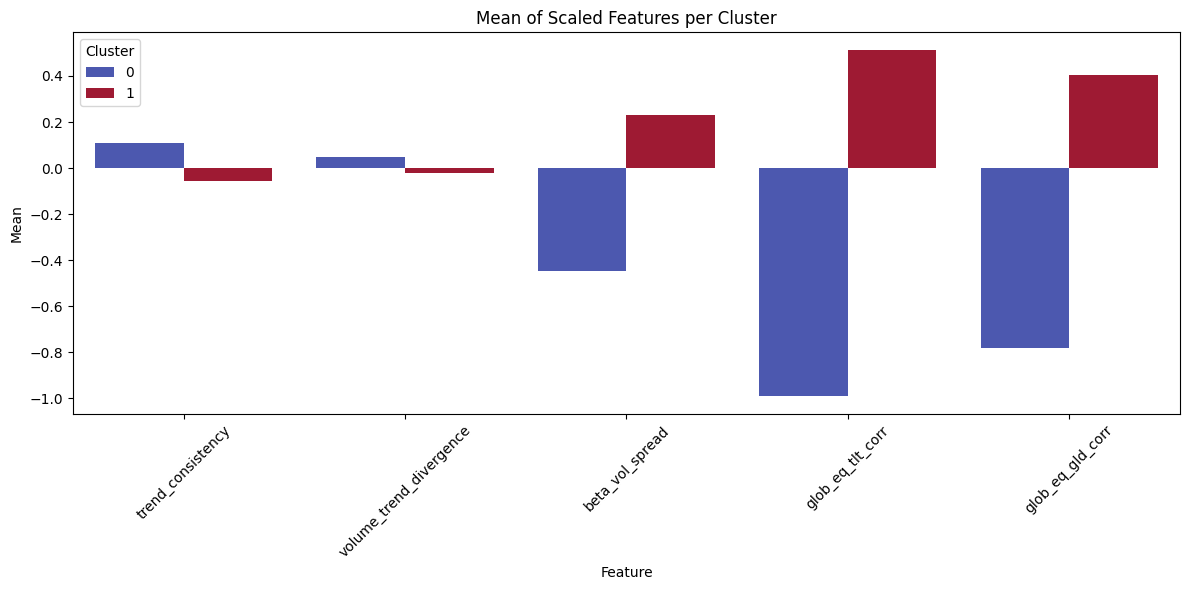

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame with scaled features and labels
df_scaled = pd.DataFrame(scaled, columns=only_bull_features_df.columns)
df_scaled['Cluster'] = labels

# Compute mean of each feature per cluster
cluster_means = df_scaled.groupby('Cluster').mean()

# Reshape for plotting
cluster_means_melted = cluster_means.reset_index().melt(id_vars='Cluster', var_name='Feature', value_name='Mean')

# Get unique clusters and generate RdBu-based color palette
unique_clusters = sorted(cluster_means_melted['Cluster'].unique())
n_clusters = len(unique_clusters)

palette = [to_hex(cmap(i)) for i in range(n_clusters)]
cluster_color_map = {label: palette[i] for i, label in enumerate(unique_clusters)}

# Plot grouped barplot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=cluster_means_melted,
    x='Feature',
    y='Mean',
    hue='Cluster',
    palette=cluster_color_map  # Use custom RdBu palette
)
plt.title('Mean of Scaled Features per Cluster')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


In [93]:
df_2_plot = load_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE, all_tickers=['SPY'])

df_2_plot = df_2_plot.sort_values(by=['symbol', 'timestamp']) # Ensure sorted for correct rolling calcs
# remove first days that do not have cluster
df_2_plot =  df_2_plot[len(df_2_plot)-len(df_trend_feat):]

# Merge cluster labels into df_2_plot
df_with_clusters = df_2_plot.copy()
# Prepare the dataframe with timestamp index and cluster labels
df_time_clustered = only_bull_features_df.copy()
df_time_clustered['Cluster'] = labels
df_time_clustered = df_time_clustered.sort_index()  # Ensure it's sorted by time

# fill other non-bull days with -1
df_with_clusters['Cluster'] = df_time_clustered['Cluster'].reindex(df_2_plot.index).fillna(-1)

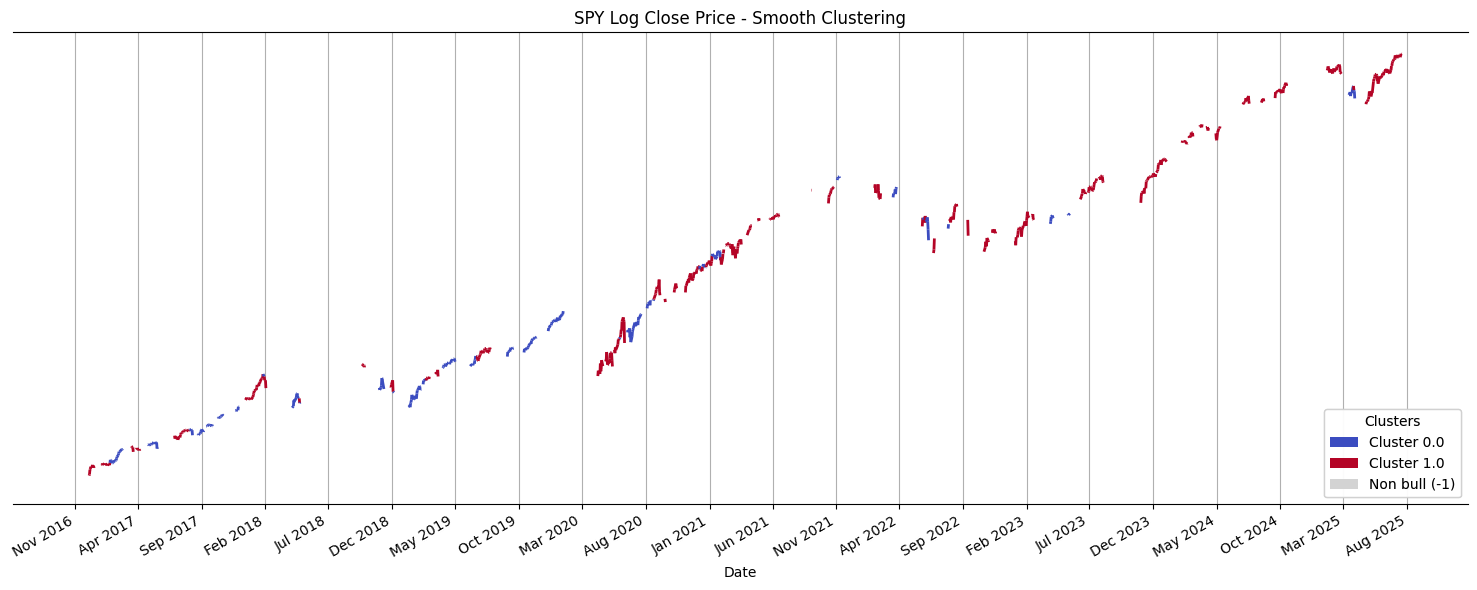

In [94]:
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib.patches import Patch

# Prepare data for colored line segments
dates = df_with_clusters.index
# Prepare data for original line
dates = df_with_clusters.index
date_nums = mdates.date2num(dates)

# Scaled log close price
close_prices_scaled = np.log(df_with_clusters['close'].values)
clusters_smooth = df_with_clusters['Cluster'].values

# Create line segments for original line
points = np.array([date_nums, close_prices_scaled]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Filter valid clusters (exclude -1 0 non-bull clusters)
valid_clusters = clusters_smooth[clusters_smooth != -1]
norm = plt.Normalize(valid_clusters.min(), valid_clusters.max())


# Prepare array for colors: NaN for noise so LineCollection ignores color mapping
color_array = np.where(clusters_smooth[:-1] == -1, np.nan, clusters_smooth[:-1])

# LineCollection
lc1 = LineCollection(segments, cmap=cmap, norm=norm)
lc1.set_array(color_array)
lc1.set_linewidth(2)

# Plot
fig, ax = plt.subplots(figsize=(15, 6))
ax.add_collection(lc1)
ax.autoscale()
ax.set_title("SPY Log Close Price - Smooth Clustering")
ax.set_xlabel("Date")

# Remove y-axis
ax.set_ylabel("")
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True)

# Format x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate()

# Legend (only valid clusters, gray for noise)
unique_clusters1 = [c for c in np.unique(clusters_smooth) if c != -1]
legend_elements1 = [Patch(facecolor=cmap(norm(c)), label=f'Cluster {c}') for c in unique_clusters1]
legend_elements1.append(Patch(facecolor='lightgray', label='Non bull (-1)'))  # add noise separately
legend1 = ax.legend(handles=legend_elements1, loc="lower right", title="Clusters")
ax.add_artist(legend1)

plt.tight_layout()
plt.show()